In [59]:
import glob
import pandas as pd
import numpy as np
import re

# Project idea and description...


Tadatadatada

# Data aquisition

In the first ... 

We need to get all the following keywords from twitter :

abu sayyaf,
afghanistan,
agro,
al-qaeda,
al-qaeda in the arabian peninsula,
al-qaeda in the islamic maghreb,
al-shabaab,
ammonium nitrate,
attack,
biological weapon,
car bomb,
chemical weapon,
conventional weapon,
dirty bomb,
eco-terrorism,
environmental terrorism,
euskadi ta askatasuna,
extremism,
farc,
fundamentalism,
hamas,
hezbollah,
improvised explosive device,
iran,
iraq,
irish republican army,
islamist,
jihad,
nationalism,
nigeria,
nuclear,
nuclear enrichment,
pakistan,
palestine liberation front,
pirates,
plo,
political radicalism,
recruitment,
somalia,
suicide attack,
suicide bomber,
taliban,
tamil tigers,
tehrik-i-taliban pakistan,
terror,
terrorism,
weapons-grade,
yemen,

## Analysis of the tweets

### Interrupted time series with regression
We will now focus on getting an understanding of the tweet distribution over time, and how the massive revelations of online surveillance in June 2013 might have caused a chilling effect. We will follow the paper's original way of doing the interrupted time series, with regression analysis.

First, let's see what those big files yield by reading one. We need to first find all the archives.

In [42]:
archive_pathnames = glob.glob('./data/*.gz')
print(f"Found {len(archive_pathnames)} archives")

Found 44 archives


Now, what is in the first archive ?

In [46]:
df = pd.read_csv(archive_pathnames[0])
print(df.shape)
df.head()

(9299, 22)


,id,conversation_id,created_at,date,time,user_id,username,name,tweet,language,...,photos,replies_count,retweets_count,likes_count,hashtags,link,retweet,video,thumbnail,reply_to
0,506278868614148097,506278868614148097,2014-09-01 05:14:23 CEST,2014-09-01,05:14:23,8.343178e+07,starman1981,truckerstrong news,ISIS laptop reveals terror group were working ...,en,...,[],0,0.0,0.0,[],https://twitter.com/starman1981/status/5062788...,False,False,NaN,[]
1,506272708037214208,506272708037214208,2014-09-01 04:49:54 CEST,2014-09-01,04:49:54,7.134575e+08,patriotsorg,Patriots Billboard,#SEIZED ISIS LAPTOP REVEALS THEY’RE DEVELOPING...,en,...,[],0,3.0,1.0,['seized'],https://twitter.com/PatriotsOrg/status/5062727...,False,False,NaN,[]
2,506263382459428864,506263382459428864,2014-09-01 04:12:50 CEST,2014-09-01,04:12:50,2.630728e+08,mlgeek,My Little Geek,@bjorntipling Perhaps Swift is a biological we...,en,...,[],0,0.0,0.0,[],https://twitter.com/mlgeek/status/506263382459...,False,False,NaN,[]
3,506261754197061632,506261754197061632,2014-09-01 04:06:22 CEST,2014-09-01,04:06:22,2.510451e+09,msgubot,Cédric Moro (backup),G+ #ebola USA created Ebola virus as biologica...,en,...,[],0,0.0,0.0,['ebola'],https://twitter.com/MSGUBOT/status/50626175419...,False,False,NaN,[]
4,506239829819281408,506239829819281408,2014-09-01 02:39:15 CEST,2014-09-01,02:39:15,7.134575e+08,patriotsorg,Patriots Billboard,#SEIZED ISIS LAPTOP REVEALS THEY’RE DEVELOPING...,en,...,[],1,2.0,1.0,['seized'],https://twitter.com/PatriotsOrg/status/5062398...,False,False,NaN,[]


We see a lot of information there. But what we are interested in is the user interactions around a topic that they might the government to track, for example. Therefore, we can count the number of tweets themselves, not any of their content or information, but also the number of likes and rerplies ! Each of these actions can make the user fear such surveillance. Retweets also, but because we also collect the retweets themselves, they are already there ! Therefore, we will first count the number of tweets per month, with the number of likes and retweets added as well.

In [58]:
# Keep only interesting columns and sum them all together by month. We set to parse dates so we can group by month
df = pd.read_csv(archive_pathnames[0], usecols=["date", "likes_count", "replies_count"], parse_dates=["date"], lineterminator='\n')
df["tweet_count"] = 1
grouped_df = df.set_index('date').groupby(pd.Grouper(freq='M')).sum()
grouped_df["user_interactions"] = grouped_df["likes_count"] +  grouped_df["tweet_count"] +  grouped_df["replies_count"]

grouped_df.head()

,replies_count,likes_count,tweet_count,user_interactions
date,,,,
2012-01-31,49,51,207,307
2012-02-29,33,27,177,237
2012-03-31,37,10,192,239
2012-04-30,40,32,156,228
2012-05-31,46,17,237,300


We will want to merge all twitter keyworkds into the same dataframe, therefore we will give the name of the keywork to the column where all values are summed, instead of just user_interactions. Let's extract the name from the archive path.

In [60]:
print(archive_pathnames[0])

./data/biological weapon_full.gz


In [61]:
# Knowing what the file path looks like, we can extract the name
name = re.search(r"(?<=data/).*?(?=_full)", archive_pathnames[0]).group(0)
name

'biological weapon'

In [64]:
# Just set this name to the column and go to the next zip !
grouped_df.rename(columns={"user_interactions": name}, inplace=True)
grouped_df.head()

,replies_count,likes_count,tweet_count,biological weapon
date,,,,
2012-01-31,49,51,207,307
2012-02-29,33,27,177,237
2012-03-31,37,10,192,239
2012-04-30,40,32,156,228
2012-05-31,46,17,237,300


Let's now implement a for loop to aggregate all the data.

In [ ]:
# print(pd.read_csv(archive_pathnames[0], usecols=["date", "likes_count"]))
monthly_counts = pd.DataFrame([])

for archive_pathname in archive_pathnames:
    print(f"Reading {archive_pathname} file")
    df = pd.read_csv(archive_pathname, usecols=["date", "likes_count", "replies_count"], parse_dates=["date"], lineterminator='\n')
    print(f"Shape is : {df.shape} \n")

    df["tweet_count"] = 1
    df = df.set_index('date').groupby(pd.Grouper(freq='M')).sum()
    df["user_interactions"] = df["likes_count"] +  df["tweet_count"] +  df["replies_count"]
    name = re.search(r"(?<=data/).*?(?=_full)", archive_pathname).group(0)

    df.rename(columns={"user_interactions": name}, inplace=True)
    
    monthly_counts = pd.concat([monthly_counts, df[name]], axis=1)
monthly_counts.index = pd.to_datetime(monthly_counts.index) # Make sure it is datetime

In [76]:
print(f"We have {np.round(monthly_counts.sum().sum()/1000000, 2)} million actions !")

We have 130.87 million actions !


In [77]:
# Temporary to get working faster !
# monthly_counts.to_csv("./monthly_actions.csv")
# monthly_counts = pd.read_csv("./monthly_actions.csv")

We will now have a quick glance at all the values we have.

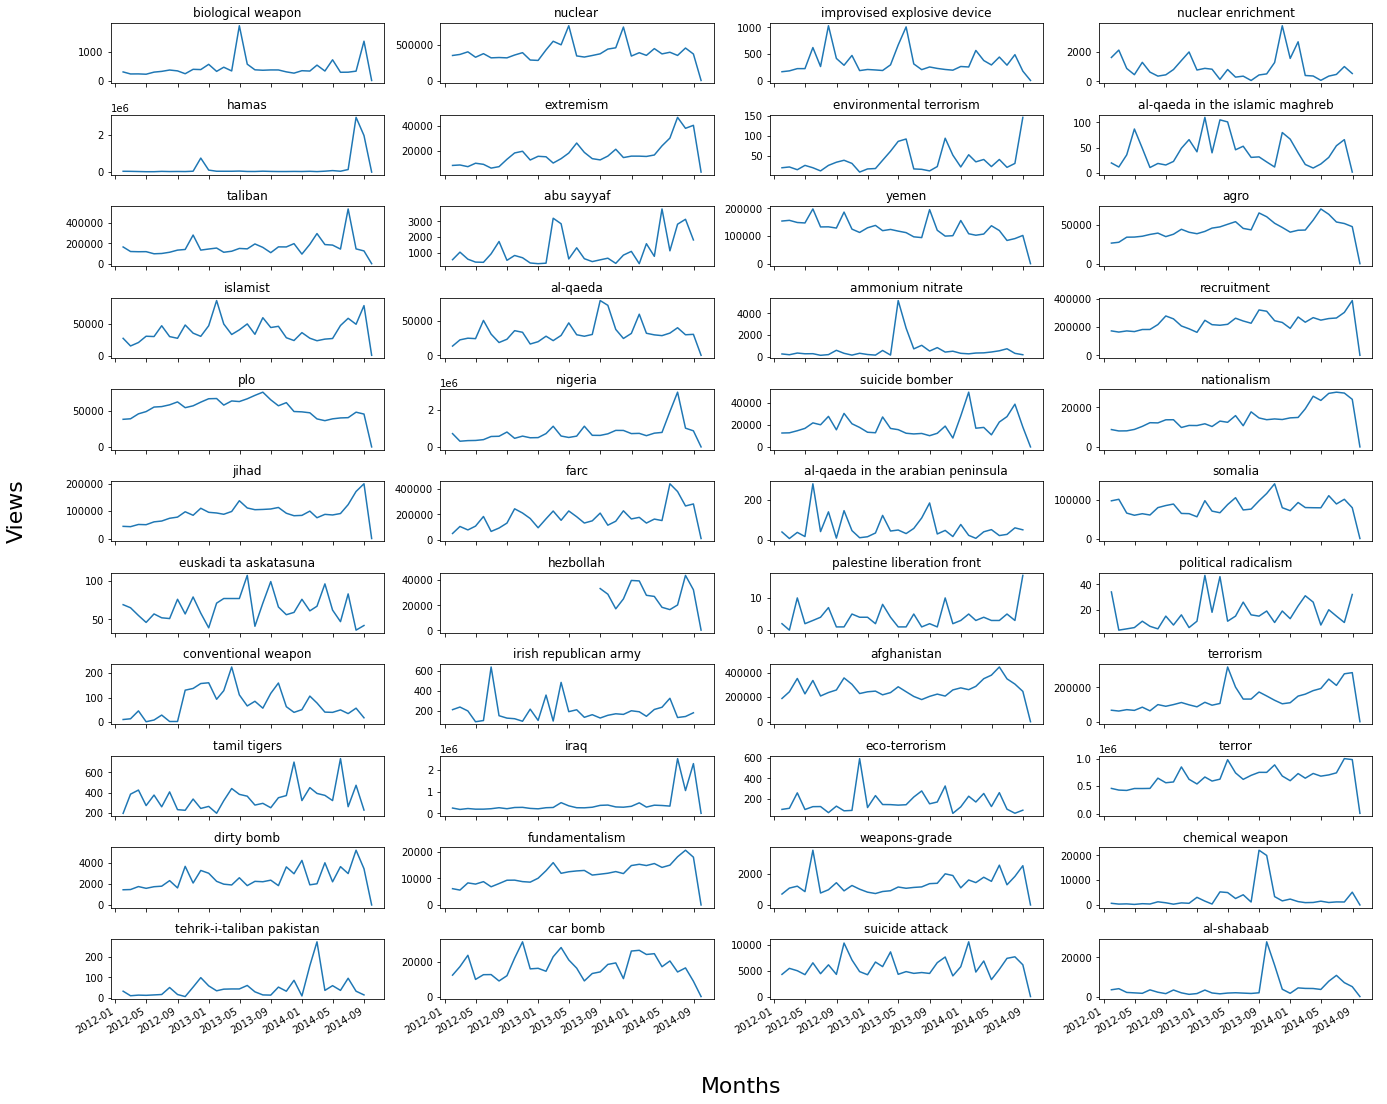

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# define figure
fig = plt.figure(figsize=(20, 16))

# big frame for main labels
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, pad=60)
plt.grid(False)
plt.xlabel("Months", fontsize=22)
plt.ylabel("Views", fontsize=22)

# define number of columns and rows of plot
col = 4
row = len(monthly_counts.columns)//col

# plot all topics
ax = fig.subplots(row, col, sharey=False, sharex=True)

for i, article_name in enumerate(monthly_counts):
    axis = ax[i//col, i%col]
    sns.lineplot(data=monthly_counts[f"{article_name}"], ax=axis)
    axis.set_title(article_name)
    plt.setp(axis.get_xticklabels(), rotation=30, horizontalalignment='right')
    axis.set_ylabel("")
fig.tight_layout()

With this graph we can look for missing values, or things that look anormal. TODO : discuss the weird things once we have complete data

In the original article, they study the period of 32 months from january 2012 to end of august 2014. We will therefore restrict our period to the be the same.

In [130]:
studied_article_actions = monthly_counts["2012-01-01":"2014-08-31"]

And now we will create the interrupted time series plot, without regression first :

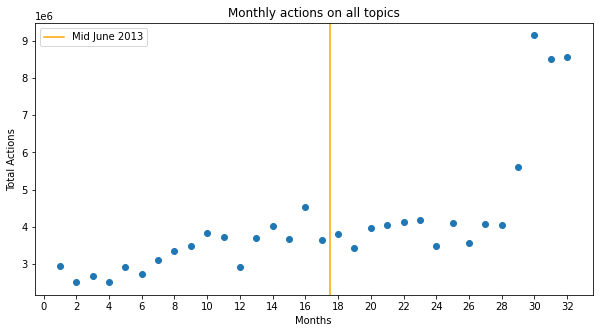

In [137]:
import numpy as np
all_actions = pd.DataFrame(studied_article_actions.sum(axis=1), columns=["actions"])
all_actions["month_nb"] = range(1, 33)

after_revelations_month = 17 # 16 first months including June 2013, but index starts at 0 so we add 1 

# define figure
fig = plt.figure(figsize=(10, 5))

# big frame for main labels
plt.title("Monthly actions on all topics")
plt.xlabel("Months")
plt.ylabel("Total Actions")
plt.xticks(np.arange(0, 33, 2.0))
plt.scatter(x=all_actions["month_nb"], y=all_actions.actions)
plt.axvline(after_revelations_month+0.5, color='orange', label='Mid June 2013') # Plot a vertical line mid June 
plt.legend()
plt.show()

Now we will do the regression, to compare the trend before and after the studied interruption.

In [138]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Do linear regression with ols
mod_before = smf.ols(formula='actions ~ month_nb',
              data=all_actions[:after_revelations_month])
res_before = mod_before.fit()

mod_after = smf.ols(formula='actions ~ month_nb',
              data=all_actions[after_revelations_month:])
res_after = mod_after.fit()

before_intercept = res_before.params[0]
before_slope = res_before.params[1]

after_intercept = res_after.params[0]
after_slope = res_after.params[1]

print(f"Before period has intercept={before_intercept} and slope={before_slope}")

print(f"After period has intercept={after_intercept} and slope={after_slope}")

Before period has intercept=2453565.1911764704 and slope=94712.80882352941
After period has intercept=-3545153.5523809567 and slope=340853.5714285714


And now, we will plot both regressions, on each side of the interruption :

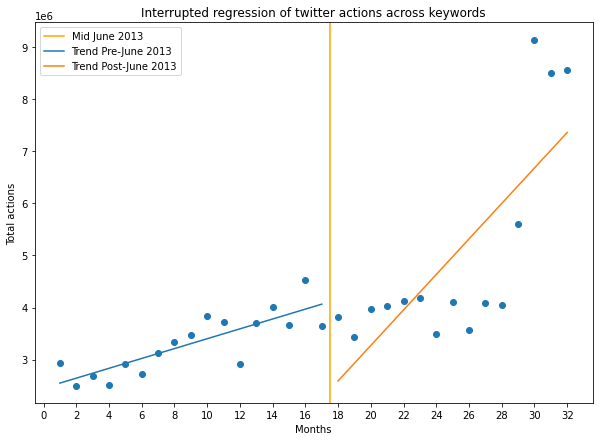

In [143]:
# define figure
fig = plt.figure(figsize=(10, 7))

# big frame for main labels
plt.title("Interrupted regression of twitter actions across keywords")
plt.xlabel("Months")
plt.ylabel("Total actions")
plt.xticks(np.arange(0, 33, 2.0))
plt.scatter(x=range(1, 33), y=all_actions.actions)
plt.axvline(after_revelations_month+0.5, color='orange', label='Mid June 2013') # Plot a vertical line mid June 

# Now we'll add the before period regression line
plt.plot(all_actions[:after_revelations_month].month_nb, all_actions[:after_revelations_month].month_nb*before_slope+before_intercept, label="Trend Pre-June 2013")

# And the after period
plt.plot(all_actions[after_revelations_month:].month_nb, all_actions[after_revelations_month:].month_nb*after_slope+after_intercept, label="Trend Post-June 2013")

plt.legend()
plt.show()